In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from matplotlib.gridspec import GridSpec

In [2]:


class PulseShapingAnalyzer:
    def __init__(self, num_symbols=8, samples_per_symbol=32):
        self.num_symbols = num_symbols
        self.samples_per_symbol = samples_per_symbol
        self.num_points = num_symbols * samples_per_symbol
        self.t = np.linspace(-num_symbols/2, num_symbols/2, self.num_points)
        self.df = 1/(num_symbols)  # Frequency resolution
        self.f = np.linspace(-4, 4, self.num_points)  # Normalized frequency

    def raised_cosine(self, alpha=0.35):
        """Generate raised cosine pulse"""
        h_t = np.zeros_like(self.t)

        # Handle special cases
        zero_idx = np.abs(self.t) < 1e-10
        h_t[zero_idx] = 1

        # Handle regular points
        non_zero = ~zero_idx & (np.abs(self.t) != 1/(2*alpha))
        h_t[non_zero] = np.sinc(self.t[non_zero]) * \
                        np.cos(np.pi*alpha*self.t[non_zero]) / \
                        (1 - (2*alpha*self.t[non_zero])**2)

        # Handle points at t = ±1/(2α)
        special_idx = np.abs(np.abs(self.t) - 1/(2*alpha)) < 1e-10
        h_t[special_idx] = (np.pi/4) * np.sinc(1/(2*alpha))

        # Calculate frequency response
        H_f = np.zeros_like(self.f)
        f_abs = np.abs(self.f)

        # Passband
        idx1 = f_abs <= (1-alpha)/(2)
        H_f[idx1] = 1

        # Transition band
        idx2 = (f_abs > (1-alpha)/2) & (f_abs <= (1+alpha)/2)
        H_f[idx2] = 0.5 * (1 + np.cos((np.pi/(alpha))*(f_abs[idx2] - (1-alpha)/2)))

        return h_t/np.max(h_t), H_f

    def root_raised_cosine(self, alpha=0.35):
        """Generate root raised cosine pulse"""
        h_t = np.zeros_like(self.t)

        # Handle special cases
        zero_idx = np.abs(self.t) < 1e-10
        h_t[zero_idx] = 1

        # Handle regular points
        non_zero = ~zero_idx
        beta = alpha

        h_t[non_zero] = (np.sin(np.pi*self.t[non_zero]*(1-beta)) + \
                        4*beta*self.t[non_zero]*np.cos(np.pi*self.t[non_zero]*(1+beta))) / \
                        (np.pi*self.t[non_zero]*(1-(4*beta*self.t[non_zero])**2))

        # Calculate frequency response
        H_f = np.zeros_like(self.f)
        f_abs = np.abs(self.f)

        # Passband and transition band
        idx = f_abs <= (1+alpha)/2
        H_f[idx] = np.sqrt(np.where(f_abs[idx] <= (1-alpha)/2,
                                   1,
                                   0.5*(1 + np.cos((np.pi/alpha)*(f_abs[idx] - (1-alpha)/2)))))

        return h_t/np.max(h_t), H_f

    def duobinary(self):
        """Generate duobinary pulse"""
        h_t = np.sinc(self.t) * (1 + np.cos(np.pi*self.t))

        # Frequency response
        H_f = np.zeros_like(self.f)
        f_abs = np.abs(self.f)
        idx = f_abs <= 1
        H_f[idx] = 2*np.cos(np.pi*self.f[idx]/2)

        return h_t/np.max(h_t), H_f

    def modified_duobinary(self):
        """Generate modified duobinary pulse"""
        h_t = np.sinc(self.t) * np.sin(np.pi*self.t)

        # Frequency response
        H_f = np.zeros_like(self.f)
        f_abs = np.abs(self.f)
        idx = f_abs <= 1
        H_f[idx] = 2*np.sin(np.pi*self.f[idx]/2)

        return h_t/np.max(h_t), H_f

    def calculate_metrics(self, h_t, H_f):
        """Calculate pulse shaping metrics"""
        metrics = {}

        # Bandwidth metrics
        metrics['bandwidth_3db'] = 2 * self.f[np.where(np.abs(H_f) >= 0.707)[0][-1]]
        metrics['bandwidth_99'] = 2 * self.f[np.where(np.abs(H_f) >= 0.01)[0][-1]]

        # ISI metric (deviation from zero crossings)
        zero_crossings = np.where(np.abs(self.t - np.round(self.t)) < 1e-10)[0]
        if len(zero_crossings) > 0:
            metrics['isi_metric'] = np.mean(np.abs(h_t[zero_crossings]))
        else:
            metrics['isi_metric'] = np.nan

        # Peak-to-sidelobe ratio
        main_lobe = np.max(np.abs(h_t))
        side_lobes = np.abs(h_t[np.abs(self.t) > 0.5])
        if len(side_lobes) > 0:
            metrics['peak_to_sidelobe'] = 20 * np.log10(main_lobe / np.max(side_lobes))
        else:
            metrics['peak_to_sidelobe'] = np.nan

        return metrics

    def plot_comparison(self, alphas=[0.1, 0.35, 0.9]):
        """Plot comparison of different pulse shapes with various roll-off factors"""
        fig = plt.figure(figsize=(15, 10))
        gs = GridSpec(3, 2)

        # Time domain comparison
        ax1 = fig.add_subplot(gs[0, :])
        ax2 = fig.add_subplot(gs[1, :])
        ax3 = fig.add_subplot(gs[2, 0])
        ax4 = fig.add_subplot(gs[2, 1])

        # Plot RC and RRC for different alphas
        for alpha in alphas:
            # Raised Cosine
            h_rc, H_rc = self.raised_cosine(alpha)
            ax1.plot(self.t, h_rc, label=f'RC α={alpha}')
            ax2.plot(self.f, np.abs(H_rc), label=f'RC α={alpha}')

            # Root Raised Cosine
            h_rrc, H_rrc = self.root_raised_cosine(alpha)
            ax1.plot(self.t, h_rrc, '--', label=f'RRC α={alpha}')
            ax2.plot(self.f, np.abs(H_rrc), '--', label=f'RRC α={alpha}')

        # Duobinary and Modified Duobinary
        h_duo, H_duo = self.duobinary()
        h_mduo, H_mduo = self.modified_duobinary()

        ax3.plot(self.t, h_duo, label='Duobinary')
        ax3.plot(self.t, h_mduo, '--', label='Modified Duobinary')

        ax4.plot(self.f, np.abs(H_duo), label='Duobinary')
        ax4.plot(self.f, np.abs(H_mduo), '--', label='Modified Duobinary')

        # Formatting
        ax1.set_title('Time Domain Response')
        ax1.set_xlabel('Normalized Time (t/T)')
        ax1.set_ylabel('Amplitude')
        ax1.grid(True)
        ax1.legend()

        ax2.set_title('Frequency Domain Response')
        ax2.set_xlabel('Normalized Frequency (fT)')
        ax2.set_ylabel('Magnitude')
        ax2.grid(True)
        ax2.legend()

        ax3.set_title('Duobinary Pulses - Time Domain')
        ax3.set_xlabel('Normalized Time (t/T)')
        ax3.set_ylabel('Amplitude')
        ax3.grid(True)
        ax3.legend()

        ax4.set_title('Duobinary Pulses - Frequency Domain')
        ax4.set_xlabel('Normalized Frequency (fT)')
        ax4.set_ylabel('Magnitude')
        ax4.grid(True)
        ax4.legend()

        plt.tight_layout()
        return fig

    def print_metrics(self, alphas=[0.1, 0.35, 0.9]):
        """Print metrics for all pulse shapes"""
        print("\nPulse Shaping Metrics:\n")

        # RC and RRC metrics for different alphas
        for alpha in alphas:
            print(f"\nRaised Cosine (α={alpha}):")
            h_rc, H_rc = self.raised_cosine(alpha)
            metrics_rc = self.calculate_metrics(h_rc, H_rc)
            print(f"3dB Bandwidth: {metrics_rc['bandwidth_3db']:.3f}")
            print(f"99% Bandwidth: {metrics_rc['bandwidth_99']:.3f}")
            print(f"ISI Metric: {metrics_rc['isi_metric']:.3e}")
            print(f"Peak-to-Sidelobe Ratio: {metrics_rc['peak_to_sidelobe']:.2f} dB")

            print(f"\nRoot Raised Cosine (α={alpha}):")
            h_rrc, H_rrc = self.root_raised_cosine(alpha)
            metrics_rrc = self.calculate_metrics(h_rrc, H_rrc)
            print(f"3dB Bandwidth: {metrics_rrc['bandwidth_3db']:.3f}")
            print(f"99% Bandwidth: {metrics_rrc['bandwidth_99']:.3f}")
            print(f"ISI Metric: {metrics_rrc['isi_metric']:.3e}")
            print(f"Peak-to-Sidelobe Ratio: {metrics_rrc['peak_to_sidelobe']:.2f} dB")

        print("\nDuobinary:")
        h_duo, H_duo = self.duobinary()
        metrics_duo = self.calculate_metrics(h_duo, H_duo)
        print(f"3dB Bandwidth: {metrics_duo['bandwidth_3db']:.3f}")
        print(f"99% Bandwidth: {metrics_duo['bandwidth_99']:.3f}")
        print(f"ISI Metric: {metrics_duo['isi_metric']:.3e}")
        print(f"Peak-to-Sidelobe Ratio: {metrics_duo['peak_to_sidelobe']:.2f} dB")

        print("\nModified Duobinary:")
        h_mduo, H_mduo = self.modified_duobinary()
        metrics_mduo = self.calculate_metrics(h_mduo, H_mduo)
        print(f"3dB Bandwidth: {metrics_mduo['bandwidth_3db']:.3f}")
        print(f"99% Bandwidth: {metrics_mduo['bandwidth_99']:.3f}")
        print(f"ISI Metric: {metrics_mduo['isi_metric']:.3e}")
        print(f"Peak-to-Sidelobe Ratio: {metrics_mduo['peak_to_sidelobe']:.2f} dB")



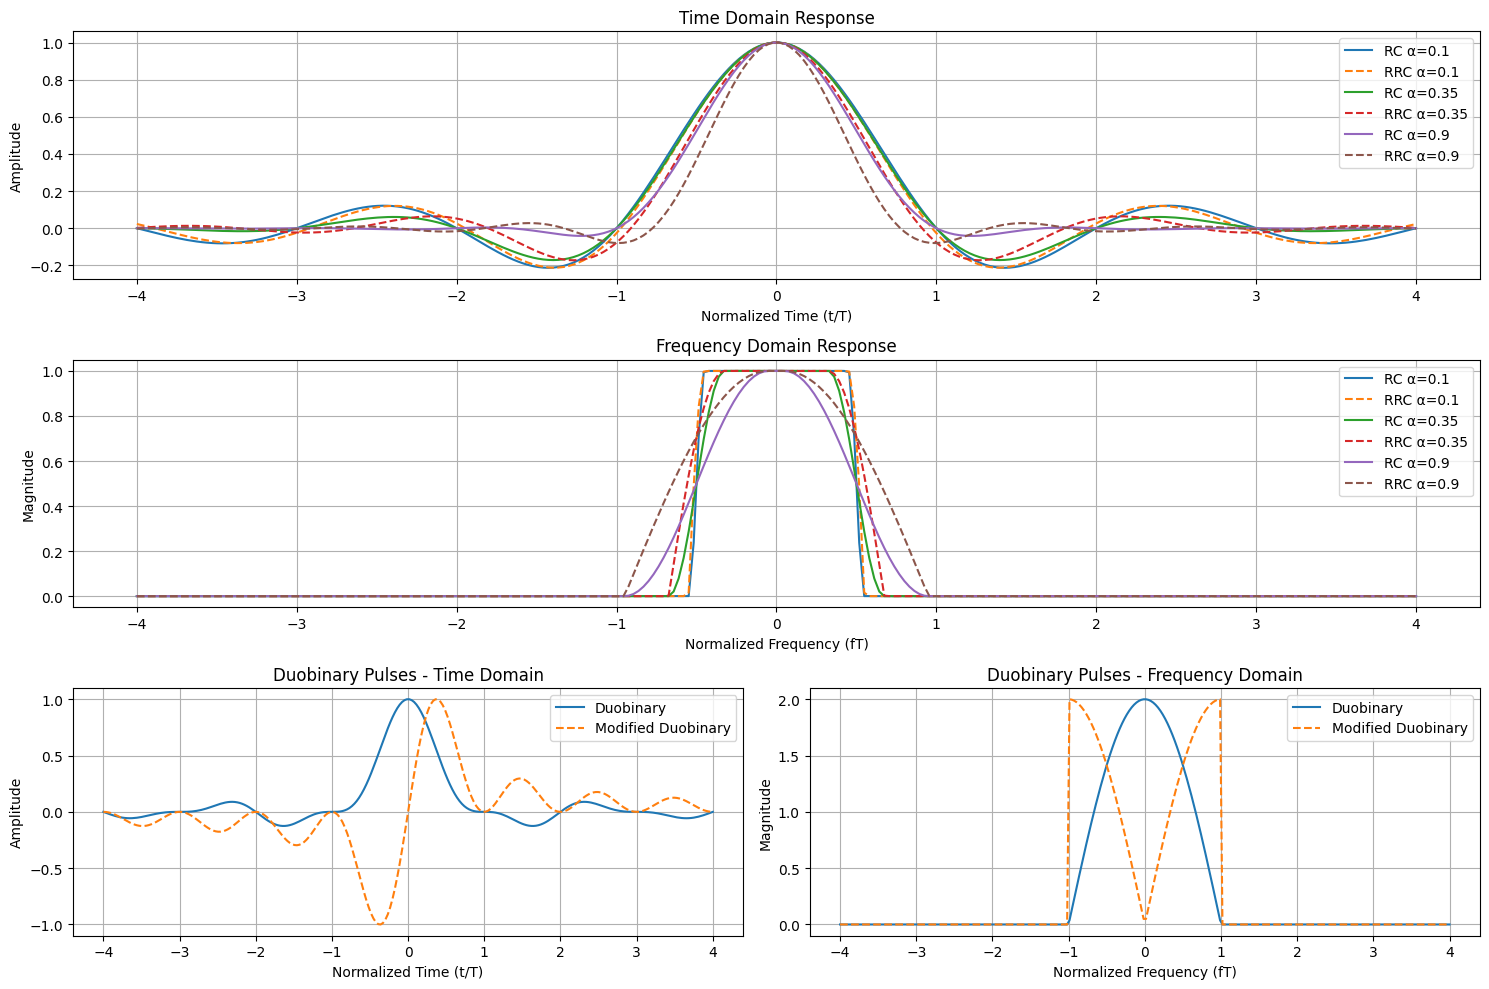


Pulse Shaping Metrics:


Raised Cosine (α=0.1):
3dB Bandwidth: 0.973
99% Bandwidth: 1.035
ISI Metric: 3.347e-17
Peak-to-Sidelobe Ratio: 4.26 dB

Root Raised Cosine (α=0.1):
3dB Bandwidth: 0.973
99% Bandwidth: 1.098
ISI Metric: 2.268e-02
Peak-to-Sidelobe Ratio: 4.52 dB

Raised Cosine (α=0.35):
3dB Bandwidth: 0.847
99% Bandwidth: 1.286
ISI Metric: 1.762e-18
Peak-to-Sidelobe Ratio: 4.50 dB

Root Raised Cosine (α=0.35):
3dB Bandwidth: 0.973
99% Bandwidth: 1.286
ISI Metric: 1.866e-03
Peak-to-Sidelobe Ratio: 5.53 dB

Raised Cosine (α=0.9):
3dB Bandwidth: 0.722
99% Bandwidth: 1.725
ISI Metric: 2.371e-19
Peak-to-Sidelobe Ratio: 6.05 dB

Root Raised Cosine (α=0.9):
3dB Bandwidth: 0.973
99% Bandwidth: 1.851
ISI Metric: 1.673e-03
Peak-to-Sidelobe Ratio: 9.39 dB

Duobinary:
3dB Bandwidth: 1.537
99% Bandwidth: 1.976
ISI Metric: 3.902e-17
Peak-to-Sidelobe Ratio: 10.74 dB

Modified Duobinary:
3dB Bandwidth: 1.976
99% Bandwidth: 1.976
ISI Metric: 2.638e-32
Peak-to-Sidelobe Ratio: 1.45 dB


In [3]:
if __name__ == "__main__":
    # Create analyzer
    analyzer = PulseShapingAnalyzer(num_symbols=8, samples_per_symbol=32)

    # Plot comparisons
    alphas = [0.1, 0.35, 0.9]
    fig = analyzer.plot_comparison(alphas)
    plt.show()

    # Print metrics
    analyzer.print_metrics(alphas)